# Caltech 101 dataset object classification

This is a simple play with the caltech101 dataset.

Loading and splitting data and running some CNN networks.

Code based on:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [83]:
import os, shutil

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import cv2
from matplotlib import pyplot as plt

import keras
print("keras version: ", keras.__version__)

import tensorflow as tf
print("tensoflow version: ", tf.__version__)

import tensorflow.keras.backend as k

keras version:  3.4.1
tensoflow version:  2.17.0


In [84]:
# instructions from: https://michaelblogscode.wordpress.com/2017/10/10/reducing-and-profiling-gpu-memory-usage-in-keras-with-tensorflow-backend/

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
#tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [85]:
import cv2
import imutils
from matplotlib import pyplot as plt

def crop_brain_contour(image, plot=False):
    """
    Crop the largest contour from an image to isolate the brain region.

    Parameters:
    image (numpy.ndarray): Input image in BGR format.
    plot (bool): Whether to plot the original and cropped images. Default is False.

    Returns:
    numpy.ndarray: The cropped image containing the largest contour.
    """

    # Convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print("No contours found.")
        return image

    # Grab the largest contour
    c = max(cnts, key=cv2.contourArea)

    # Optionally, check if the contour area is large enough
    if cv2.contourArea(c) < 500:
        print("Contour area too small.")
        return image

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the new image out of the original image using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')

        plt.show()

    return new_image


In [87]:
dataset_path = 'Brain_Tumor_Dataset'
folder_names = []
folder_names = [f for f in sorted(os.listdir(dataset_path))]

print(len(folder_names))

4


# Plotting

We have the folder/classes names. Now lets load some example images.

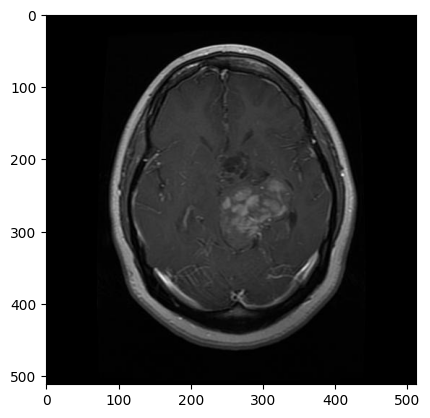

In [88]:

# Correct the path formatting and use a raw string to avoid escape sequences
image_path = r"G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\glioma_tumor\gg (1).jpg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()
else:
    print(f"Failed to load image from {image_path}")


In [89]:
print(image.shape)

(512, 512, 3)


In [90]:
# Assuming folder_names and categories_selected are defined earlier in the code
folder_names = ["Glioma_Tumor","Meningioma_Tumor","Pituitary_Tumor","No_Tumor"]  # Example list
categories_selected = [0, 1,2,3]  # Example list of selected categories

# Print the length of folder_names and categories_selected
print(f'Length of folder_names: {len(folder_names)}')
print(f'Length of categories_selected: {len(categories_selected)}')

# Print the values of categories_selected to check if they are within the valid range
print(f'Categories selected: {categories_selected}')

# Check if the values in categories_selected are within the range of folder_names
if all(i < len(folder_names) for i in categories_selected):
    # Print categories selected
    print('Selected categories:')
    print([folder_names[i] for i in categories_selected])
else:
    print("One or more indices in categories_selected are out of range.")


Length of folder_names: 4
Length of categories_selected: 4
Categories selected: [0, 1, 2, 3]
Selected categories:
['Glioma_Tumor', 'Meningioma_Tumor', 'Pituitary_Tumor', 'No_Tumor']


Dataset path: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset
Folder names: ['Glioma_Tumor', 'Meningioma_Tumor', 'Pituitary_Tumor', 'No_Tumor']
Checking folder path: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor
Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor\gg (1).jpg


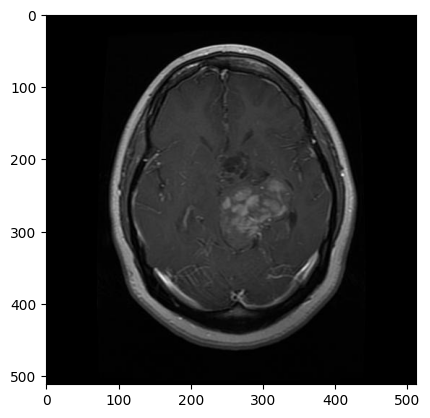

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor\gg (10).jpg


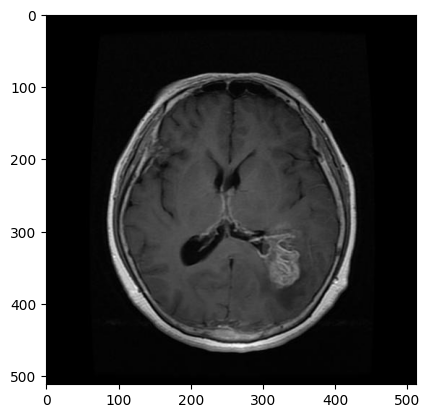

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor\gg (100).jpg


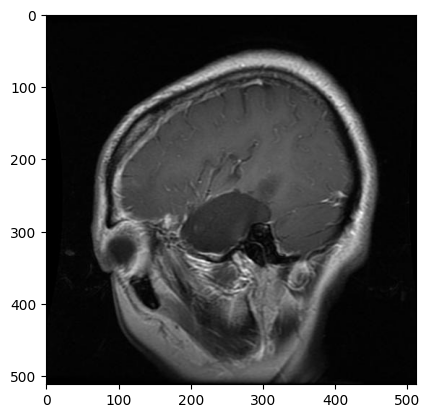

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor\gg (101).jpg


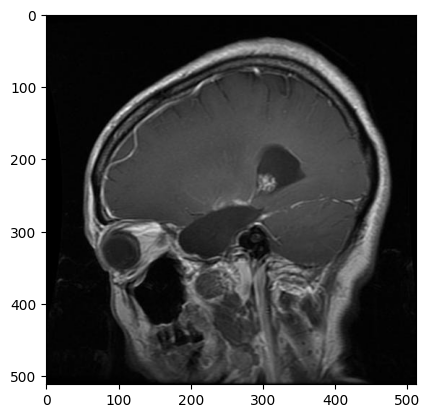

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Glioma_Tumor\gg (102).jpg


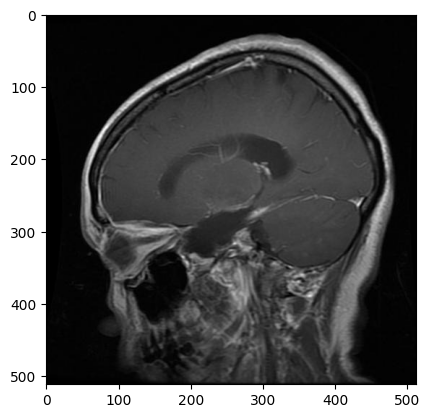

Checking folder path: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor
Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor\m (10).jpg


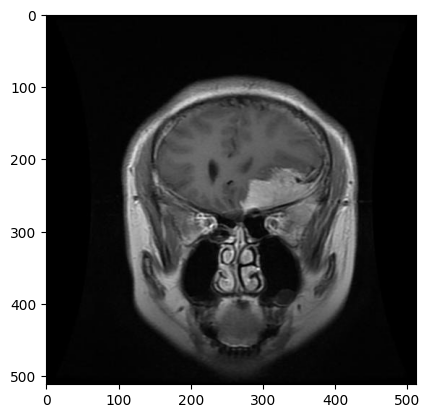

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor\m (100).jpg


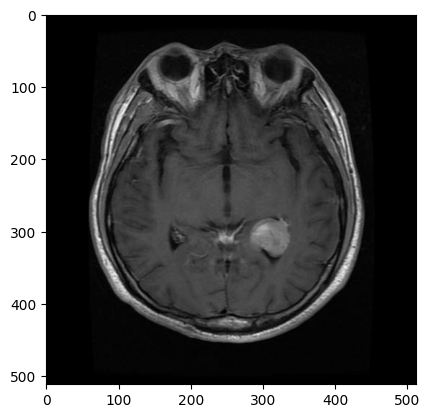

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor\m (101).jpg


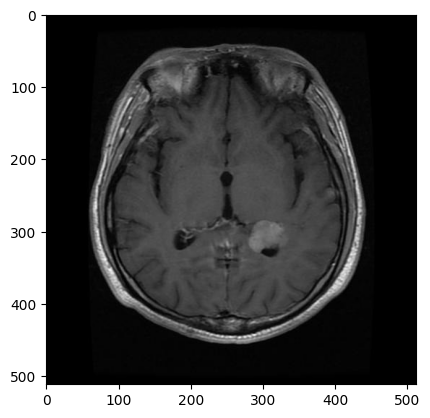

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor\m (102).jpg


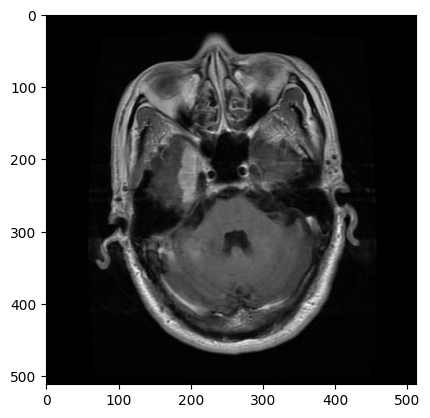

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Meningioma_Tumor\m (103).jpg


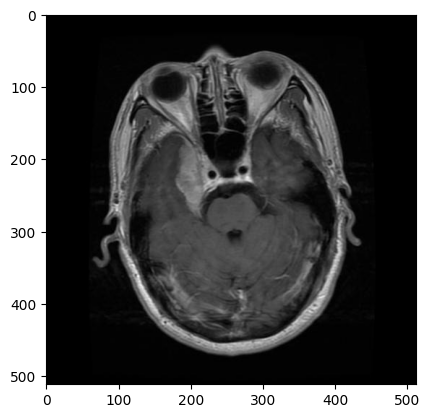

Checking folder path: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor
Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor\p (1).jpg


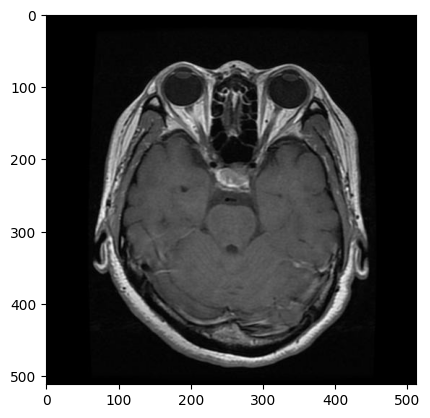

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor\p (10).jpg


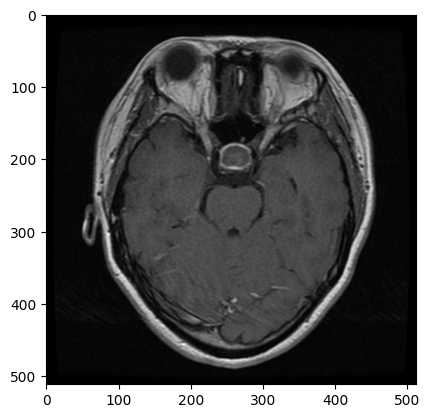

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor\p (100).jpg


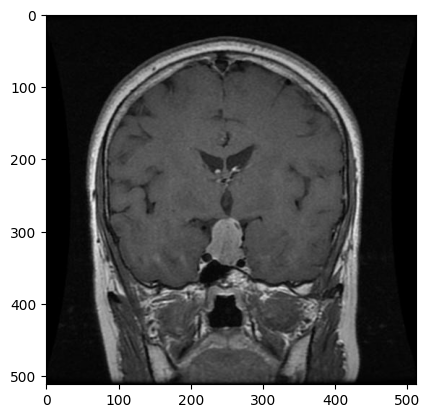

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor\p (101).jpg


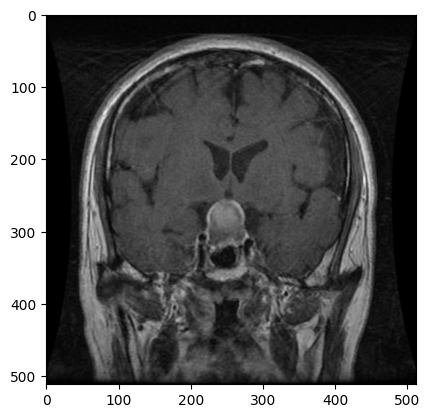

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\Pituitary_Tumor\p (102).jpg


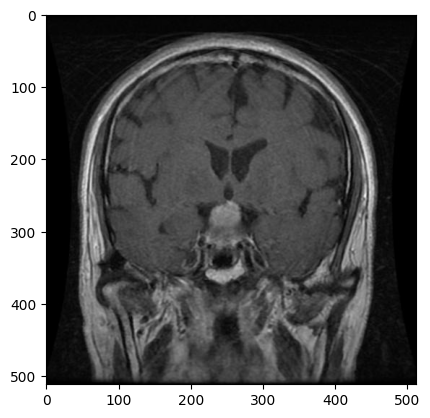

Checking folder path: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor
Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor\1.jpg


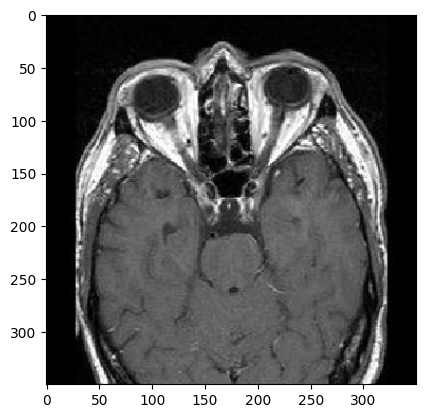

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor\2.jpg


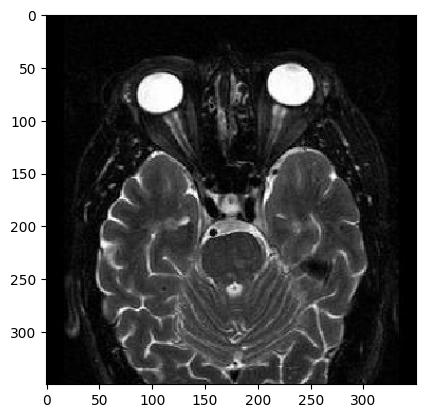

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor\3.jpg


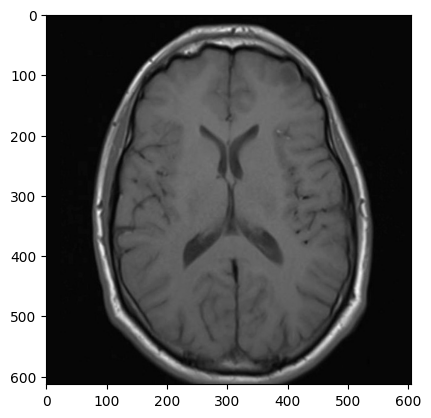

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor\4.jpg


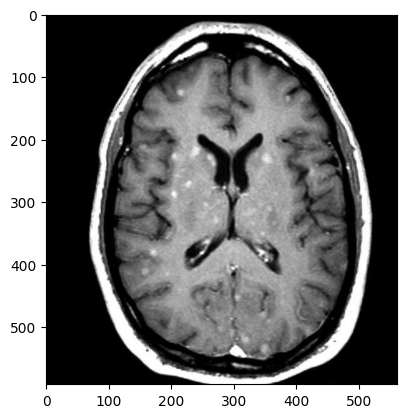

Loading image: G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset\No_Tumor\5.jpg


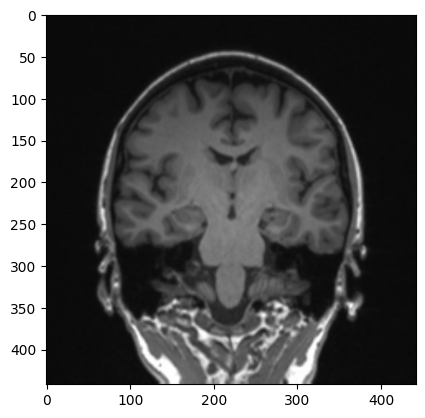

In [91]:
import os
import cv2
import matplotlib.pyplot as plt


# Assuming dataset_path and folder_names are defined
dataset_path = r"G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset"
folder_names = ["Glioma_Tumor","Meningioma_Tumor","Pituitary_Tumor","No_Tumor"]  # Example list
categories_selected = [0, 1, 2, 3]  # Example list of selected categories
images_number = 5  # Number of images to select from each category

# Print the dataset path and folder names for debugging
print(f'Dataset path: {dataset_path}')
print(f'Folder names: {folder_names}')

# Iterate over selected categories
for category in categories_selected:
    folder_path = os.path.join(dataset_path, folder_names[category])
    
    # Debug the folder path
    print(f'Checking folder path: {folder_path}')
    
    try:
        # Take the first few images
        image_names = [img for img in sorted(os.listdir(folder_path))][:images_number]
        
        for j, image_name in enumerate(image_names):
            image_path = os.path.join(folder_path, image_name)
            print(f'Loading image: {image_path}')
            # Load and process the image
            image = cv2.imread(image_path)
            if image is not None:
                # Convert the image from BGR to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(image_rgb)
                plt.show()
            else:
                print(f'Failed to load image: {image_path}')
    except FileNotFoundError:
        print(f'Folder not found: {folder_path}')


# Images count

Check how many images for each category there are. Create various useful dictionaries

In [92]:
import os

dataset_path = r'G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection\Brain_Tumor_Dataset'
folder_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor' , 'pituitary_tumor'] 

category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}

total_images = 0

for i, category in enumerate(folder_names):
    category_dict[i] = category
    
    folder_path = dataset_path + '/' + category
    image_names = [os.path.join(folder_path, img) for img in sorted(os.listdir(folder_path))]
    image_names = [img for img in sorted(os.listdir(folder_path))]
    
    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names
    
    print('%s: %d' %(category, images_per_category_dict[i]))
    total_images += images_per_category_dict[i]
    
print('Total images in dataset: %d' %(total_images))

glioma_tumor: 826
meningioma_tumor: 822
no_tumor: 395
pituitary_tumor: 827
Total images in dataset: 2870


# split dataset into train validation and test

use 70% of the images for training, 20% for validation and 10% for testing

In [93]:
# directories to use. Run the other cells ONLY ONCE to create the splitting

base_path = './split_dataset2'
train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')

In [94]:
# create the directories to use
base_path = './split_dataset10'

try:
    os.mkdir(base_path)
except FileExistsError:
    print(f"The directory {base_path} already exists.")

train_dir = os.path.join(base_path, 'train')
try:
    os.mkdir(train_dir)
except FileExistsError:
    print(f"The directory {train_dir} already exists.")

validation_dir = os.path.join(base_path, 'validation')
try:
    os.mkdir(validation_dir)
except FileExistsError:
    print(f"The directory {validation_dir} already exists.")

test_dir = os.path.join(base_path, 'test')
try:
    os.mkdir(test_dir)
except FileExistsError:
    print(f"The directory {test_dir} already exists.")

The directory ./split_dataset10 already exists.
The directory ./split_dataset10\train already exists.
The directory ./split_dataset10\validation already exists.
The directory ./split_dataset10\test already exists.


In [95]:
# create the categories files in each

# List of directories to create
directories = [train_dir, validation_dir, test_dir]

for directory in directories:
    for category in folder_names:
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            os.mkdir(category_path)
        else:
            print(f"Directory {category_path} already exists.")

Directory ./split_dataset10\train\glioma_tumor already exists.
Directory ./split_dataset10\train\meningioma_tumor already exists.
Directory ./split_dataset10\train\no_tumor already exists.
Directory ./split_dataset10\train\pituitary_tumor already exists.
Directory ./split_dataset10\validation\glioma_tumor already exists.
Directory ./split_dataset10\validation\meningioma_tumor already exists.
Directory ./split_dataset10\validation\no_tumor already exists.
Directory ./split_dataset10\validation\pituitary_tumor already exists.
Directory ./split_dataset10\test\glioma_tumor already exists.
Directory ./split_dataset10\test\meningioma_tumor already exists.
Directory ./split_dataset10\test\no_tumor already exists.
Directory ./split_dataset10\test\pituitary_tumor already exists.


In [96]:
# calculate the number of images to place in each train/valid/test categories folder

import shutil

total_train = 0
total_validation = 0
total_test = 0

total_train_2 = 0
total_validation_2 = 0
total_test_2 = 0

for i, category in enumerate(folder_names):
    train_number = int(0.7 * images_per_category_dict[i])
    validation_number = int(0.2 * images_per_category_dict[i])
    test_number = images_per_category_dict[i] - train_number - validation_number # for not exceeding maximum number
    
    # for statistics later
    total_train += train_number
    total_validation += validation_number
    total_test += test_number
    
    # now copy these images to respective folders
    # Copy first 1000 cat images to train_cats_dir
    fnames = category_images_path_dict[i][:train_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(train_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_train_2 += len(fnames)
        
    fnames = category_images_path_dict[i][train_number:train_number + validation_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(validation_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_validation_2 += len(fnames)
    
    fnames = category_images_path_dict[i][train_number + validation_number:]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(test_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_test_2 += len(fnames)


In [97]:
# print statistics

print('Correct train split: ', total_train == total_train_2)
print('Correct validation split: ', total_validation == total_validation_2)
print('Correct test split: ', total_test == total_test_2)
print()
print('Number of training images: ', total_train)
print('Number of validation images: ', total_validation)
print('Number of test images: ', total_test)
print()
print('Real percentage of training images: ', total_train / total_images)
print('Real percentage of validation images: ', total_validation / total_images)
print('Real percentage of test images: ', total_test / total_images)

Correct train split:  True
Correct validation split:  True
Correct test split:  True

Number of training images:  2007
Number of validation images:  573
Number of test images:  290

Real percentage of training images:  0.6993031358885018
Real percentage of validation images:  0.19965156794425087
Real percentage of test images:  0.10104529616724739


# Simple CNN network to learn the classes

This code is inspired/copied by the repository https://github.com/fchollet/deep-learning-with-python-notebooks that has the code from book "Deep Learning with Python".

More specifically, I am running code from the notebooks:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

adapted to the Caltech101 dataset. Please refer to the original Jupyter Notebooks above for further info.

In [142]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Input(shape=(150, 150, 3)))  # Using Input layer as the first layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


In [143]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])


data processing

In [145]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2007 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [146]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 4)


fit the model

In [147]:
train_generator = train_datagen.flow_from_directory(
    r'G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection',  # Raw string
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r'G:\Repos and code\Brain-tumar-Detection\Brain-Tumor-Detection',  # Raw string
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical'
)

Found 5740 images belonging to 3 classes.
Found 5740 images belonging to 3 classes.


save the model

In [48]:
#model.save('caltech101_1.h5')

plot the accuracies

In [148]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=80
    )
except Exception as e:
    print(f"An error occurred during model training: {e}")


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - acc: 0.4835 - loss: 0.7408 - val_acc: 0.5269 - val_loss: 0.6945
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - acc: 0.4825 - loss: 0.7036 - val_acc: 0.5131 - val_loss: 0.6951
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - acc: 0.4973 - loss: 0.7011 - val_acc: 0.5000 - val_loss: 0.7186
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - acc: 0.5061 - loss: 0.6980 - val_acc: 0.5021 - val_loss: 0.6958
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - acc: 0.5018 - loss: 0.6980 - val_acc: 0.5006 - val_loss: 0.6968


In [150]:
model.compile(
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy'
    optimizer='adam',
    metrics=['accuracy']  # or ['acc'] based on your TensorFlow/Keras version
)


Overfitting since approximately epoch 5.

# Using data augmentation

By augmenting data we can avoid overfitting.

In [151]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

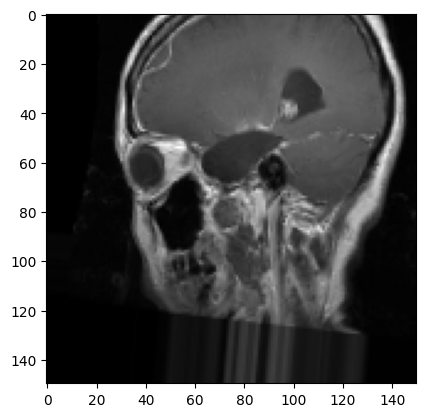

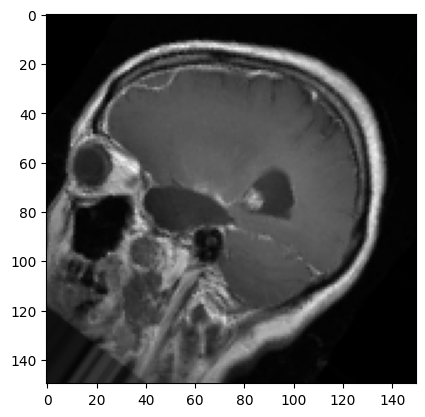

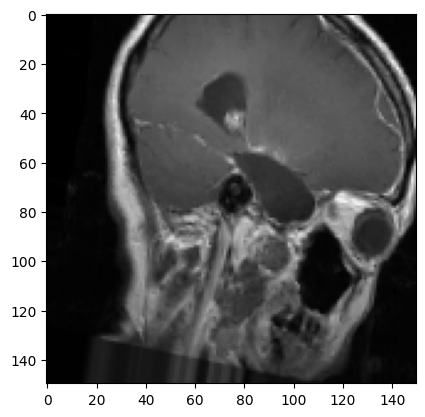

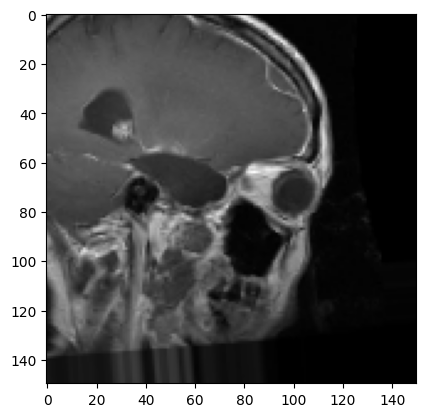

In [152]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_dir, 'glioma_tumor', fname) for fname in os.listdir(os.path.join(train_dir, 'glioma_tumor'))]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

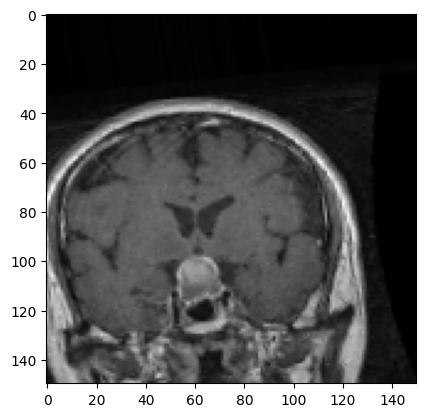

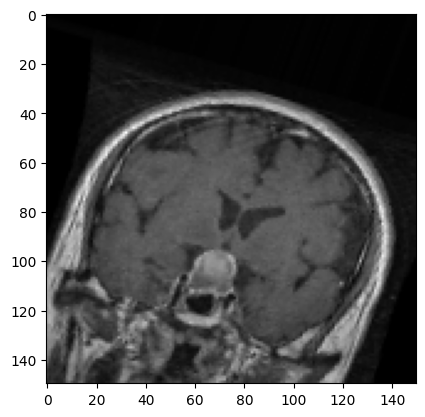

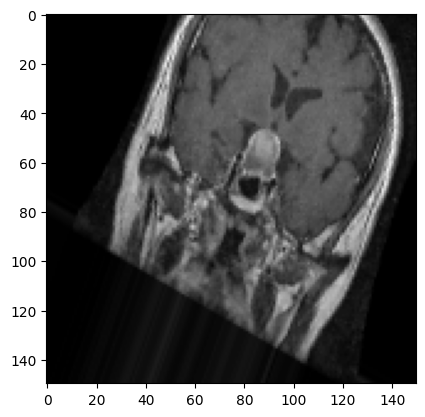

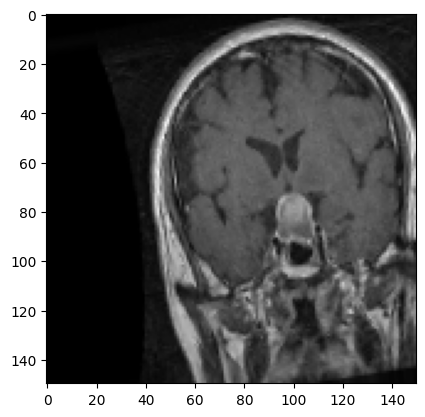

In [153]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_dir, 'pituitary_tumor', fname) for fname in os.listdir(os.path.join(train_dir, 'pituitary_tumor'))]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

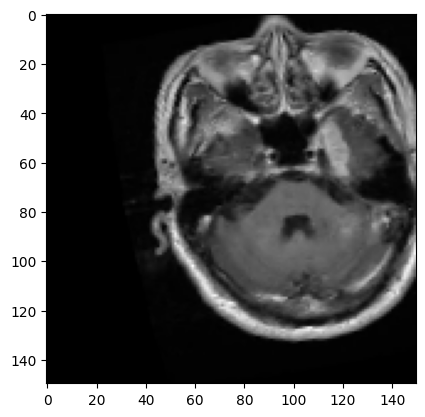

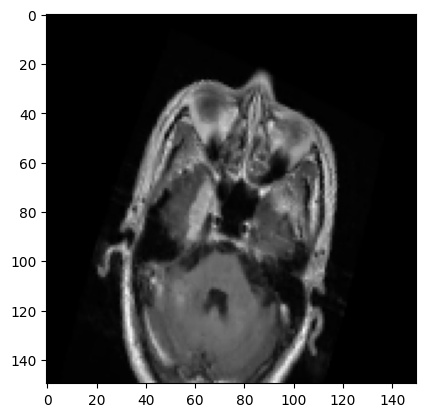

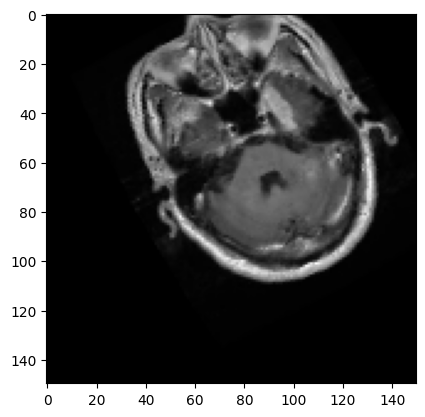

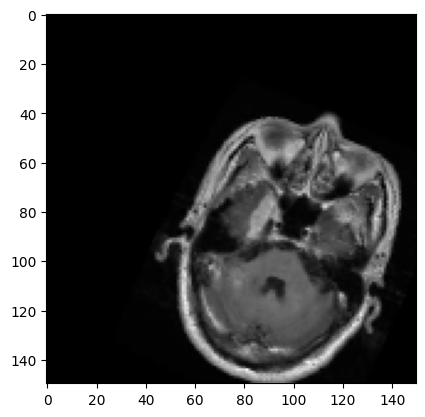

In [154]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_dir, 'meningioma_tumor', fname) for fname in os.listdir(os.path.join(train_dir, 'meningioma_tumor'))]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

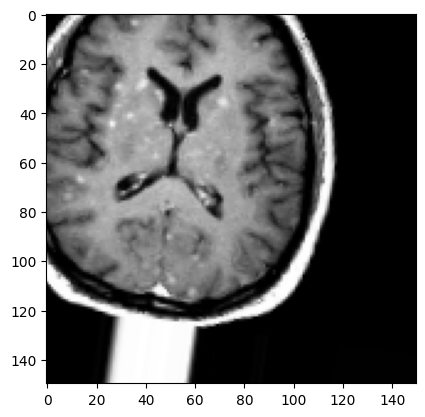

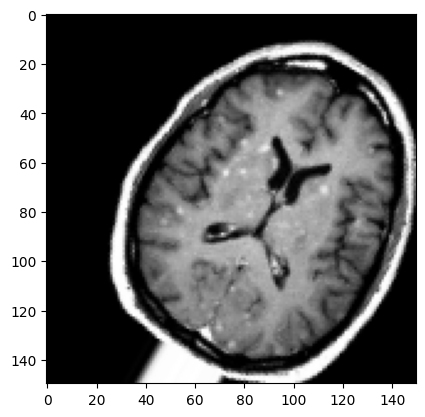

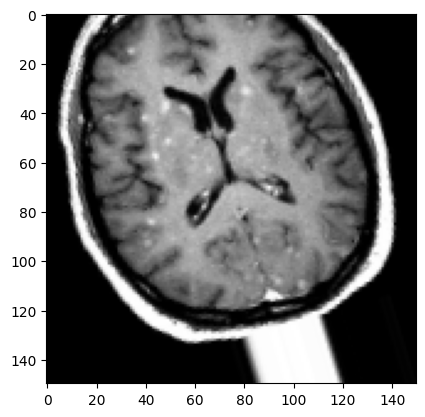

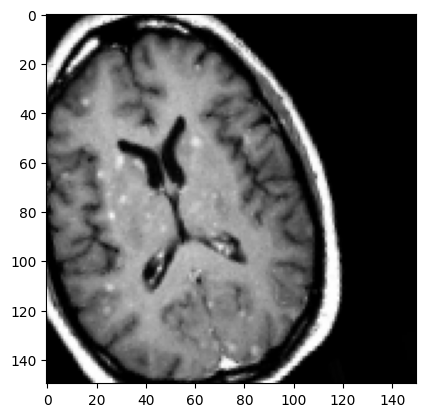

In [155]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_dir, 'no_tumor', fname) for fname in os.listdir(os.path.join(train_dir, 'no_tumor'))]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Use data augmentation and dropout:

In [156]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [162]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input

# Define the paths to your training and validation directories
base_dir = 'split_dataset10'  # Replace with your actual path
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# Define a simple CNN model using Input layer
model = models.Sequential([
    Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')  # Adjust the output layer based on the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=150,  # Adjust based on the number of images in your training set
      epochs=3,
      validation_data=validation_generator,
      validation_steps=30)  # Adjust based on the number of images in your validation set


Found 2007 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/3


C:\Users\Abhin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 63/150 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.3255 - loss: 1.3596

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3526 - loss: 1.3260 - val_accuracy: 0.4014 - val_loss: 1.3552
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.4556 - loss: 1.1797 - val_accuracy: 0.2304 - val_loss: 1.4073
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.5484 - loss: 1.0855 - val_accuracy: 0.4852 - val_loss: 1.0612


In [164]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the paths to your training and validation directories
base_dir = 'split_dataset10'  # Replace with your actual path
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Check if directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.exists(validation_dir):
    raise FileNotFoundError(f"Validation directory not found: {validation_dir}")

# Create the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Define a simple model (replace with your actual model)
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Adjust to the number of classes
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)



Found 2007 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.3461 - loss: 1.3582 - val_accuracy: 0.3438 - val_loss: 1.2424
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 1.0081 - val_accuracy: 0.3448 - val_loss: 1.3314
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.4894 - loss: 1.1361 - val_accuracy: 0.4283 - val_loss: 1.3694


In [ ]:
model.save('caltech101_2.h5')

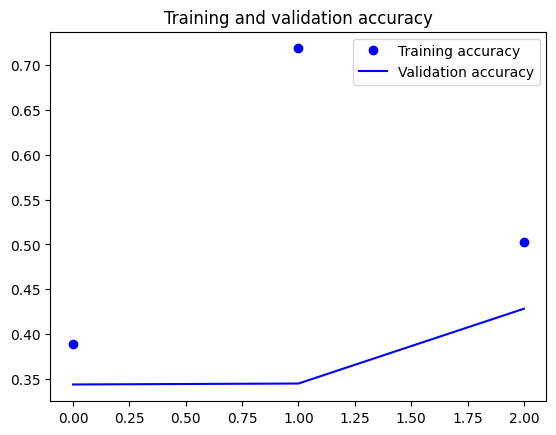

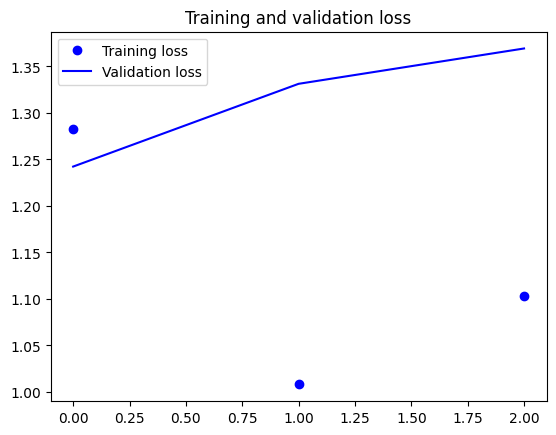

In [166]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
